<img src="https://dl.fbaipublicfiles.com/detectron2/Detectron2-Logo-Horz.png" width="100">

# Installation detectron2

In [43]:
# install dependencies:
# (use +cu100 because colab is on CUDA 10.0)
# ----------------------UNCOMMENT FROM HERE----------------------------------
# !pip install -U torch==1.4+cu100 torchvision==0.5+cu100 -f https://download.pytorch.org/whl/torch_stable.html 
# !pip install cython pyyaml==5.1
# !pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
# import torch, torchvision
# torch.__version__
# !gcc --version
# ---------------------UNCOMMENT TILL HERE-----------------------------------
# opencv is pre-installed on colab

In [44]:
# UNCOMMENT
# !git clone https://github.com/facebookresearch/detectron2 detectron2_repo
# !pip install -e detectron2_repo

Restart runtime in case you are installing detectron for the first time

In [41]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()
# common libraries
import numpy as np
import cv2
import random
import os
try:
    from google.colab.patches import cv2_imshow
except:
    os.system(f"""pip install google.colab""")
    from google.colab.patches import cv2_imshow
import glob
import matplotlib.pyplot as plt
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.structures import BoxMode

# Train on a custom dataset

If you want to use a custom dataset while also reusing detectron2’s data loaders, you will need to

* Register your dataset (i.e., tell detectron2 how to obtain your dataset).
* Optionally, register metadata for your dataset.

## Prepare the dataset

To register your dataset to detectron2, following the [detectron2 custom dataset tutorial](https://detectron2.readthedocs.io/tutorials/datasets.html).
Here, the dataset is in its custom format, therefore we write a function to parse it and prepare it into detectron2's standard format. See the tutorial for more details.


### Folder structure to follow to directly use this notebook

```
EndoCV_Det
│   class_list_bbox.txt  
│
└─── TRAIN
│      └ images
│      └ bbox
└─── VAL
│      └ images
│      └ bbox
└─── HOLDOUT  (Holdout set is optional)
       └ images
       └ bbox
```

In [33]:
def get_bb(img_path, img_name):
    """
    
        This function returns annotations in the format
        xyxy_ABS: xmin, ymin, xmax, ymax - ABSOLUTE
        
        Function built taking into consideration the dataset
        provided by EAD2020
        
        change the path to the bounding box folder(if not training on EAD)
        and change the loading method(if using .mat) accordingly
        
    """
    # change the path to the bounding box folder(if not training on EAD)
    # and change the loading method accordingly
    bb_path = img_path[:-7]+'bbox/'
    img = plt.imread(img_path+img_name)
    m, n, _ = img.shape
    labels = np.loadtxt(bb_path+img_name[:-4]+'.txt').reshape(-1, 5)
    classes = np.empty(len(labels), dtype=np.int32)
    xyxy = np.empty((len(labels), 4), dtype=np.int32)
    for i, label in enumerate(labels):
        cls, x, y, w, h = label
        x1 = (x-w/2.)
        x2 = x1 + w
        y1 = (y-h/2.)
        y2 = y1 + h
        x1 = np.clip(int(x1 * n), 0, n-1) ; x2 = np.clip(int(x2*n), 0, n-1)
        y1 = np.clip(int(y1 * m), 0, m-1) ; y2 = np.clip(int(y2*m), 0, m-1)
        classes[i] = int(cls)
        xyxy[i] = [x1, y1, x2, y2]
        
    return xyxy, classes

In [35]:
def get_dicts(phase):
    if phase == 'train':
        path = 'EndoCV_Det/TRAIN/images/'
    else:
        path = 'EndoCV_Det/VAL/images/'
    dataset_dicts = []
    img_list = os.listdir(path)
    for idx, i in enumerate(img_list):
        record = {}
        img = plt.imread(path+i)
        height, width, _ = img.shape        
        record["file_name"] = path+i
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
        proposal_bb, proposal_logits = get_bb(path, i)
        objs=[]
        for j in range(len(proposal_bb)):
            obj = {
                "bbox": [proposal_bb[j][0], proposal_bb[j][1], proposal_bb[j][2], proposal_bb[j][3]],
                "bbox_mode": BoxMode.XYXY_ABS,
                "category_id": proposal_logits[j],
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        record["thing_classes"] = ["specularity","saturation",
                                      "artifact", "blur", "contrast", "bubbles",
                                      "instrument", "blood"]
        dataset_dicts.append(record)
    return dataset_dicts

from detectron2.data import DatasetCatalog, MetadataCatalog
for d in ["train", "val"]:
    DatasetCatalog.register("endo1_" + d, get_dicts)
    MetadataCatalog.get("endo1_" + d).set(thing_classes=["specularity","saturation",
                                          "artifact", "blur", "contrast", "bubbles",
                                          "instrument", "blood"])
endo_metadata = MetadataCatalog.get("endo1_train") 

## Visualisation



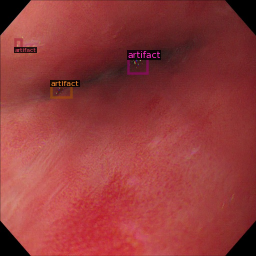

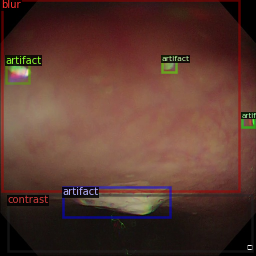

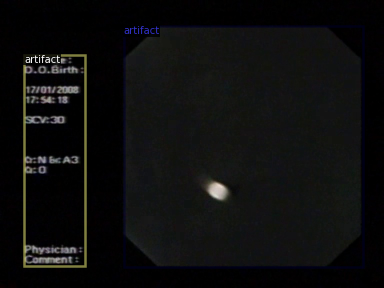

In [42]:
dataset_dicts = get_dicts('train')
for d in random.sample(dataset_dicts, 3):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=endo_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

### To choose model:
    detectron2_repo-->configs
    Accordingly choose Detection or whatever you require
    For eg:
        "detectron2_repo/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml"
### To get weights:
    detectron2_repo-->detectron2-->model_zoo-->model_zoo.py
    For eg: copy any link
        "COCO-Detection/faster_rcnn_R_50_C4_3x.yaml": "137849393/model_final_f97cb7.pkl"
    delete the mid part and add detectron2:// to the start
        "detectron2://COCO-Detection/faster_rcnn_R_50_C4_3x/137849393/model_final_f97cb7.pkl"
    use this format as a link to get the model weights

# Train

In [8]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("detectron2_repo/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("endov4_train",)
cfg.DATASETS.TEST = ()   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-Detection/retinanet_R_50_FPN_3x/137849486/model_final_4cafe0.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 300    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 8  # only has one class (ballon)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

Loading config detectron2_repo/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


[02/01 10:45:19 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[02/01 10:45:54 d2.engine.train_loop]: Starting training from iteration 0
[02/01 10:46:02 d2.utils.events]: eta: 0:01:55  iter: 19  total_loss: 2.099  loss_cls: 1.686  loss_box_reg: 0.411  time: 0.4098  data_time: 0.0164  lr: 0.000005  max_mem: 3153M
[02/01 10:46:11 d2.utils.events]: eta: 0:01:47  iter: 39  total_loss: 2.096  loss_cls: 1.674  loss_box_reg: 0.414  time: 0.4111  data_time: 0.0063  lr: 0.000010  max_mem: 3154M
[02/01 10:46:19 d2.utils.events]: eta: 0:01:40  iter: 59  total_loss: 1.822  loss_cls: 1.381  loss_box_reg: 0.406  time: 0.4154  data_time: 0.0052  lr: 0.000015  max_mem: 3154M
[02/01 10:46:27 d2.utils.events]: eta: 0:01:31  iter: 79  total_loss: 1.557  loss_cls: 1.151  loss_box_reg: 0.371  time: 0.4160  data_time: 0.0060  lr: 0.000020  max_mem: 3154M
[02/01 10:46:36 d2.utils.events]: eta: 0:01:24  iter: 99  total_loss: 1.267  loss_cls: 0.948  loss_box_reg: 0.367  time: 0.4195  data_time: 0.0057  lr: 0.000025  max_mem: 3154M
[02/01 10:46:45 d2.utils.events]: eta: 0:

In [9]:
# Look at training curves in tensorboard:
%load_ext tensorboard
%tensorboard --logdir output

## Inference & evaluation using the trained model
Now, let's run inference with the trained model on the balloon validation dataset. First, let's create a predictor using the model we just trained:



In [0]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
cfg.DATASETS.TEST = ("balloon_val", )
predictor = DefaultPredictor(cfg)

Then, we randomly select several samples to visualize the prediction results.

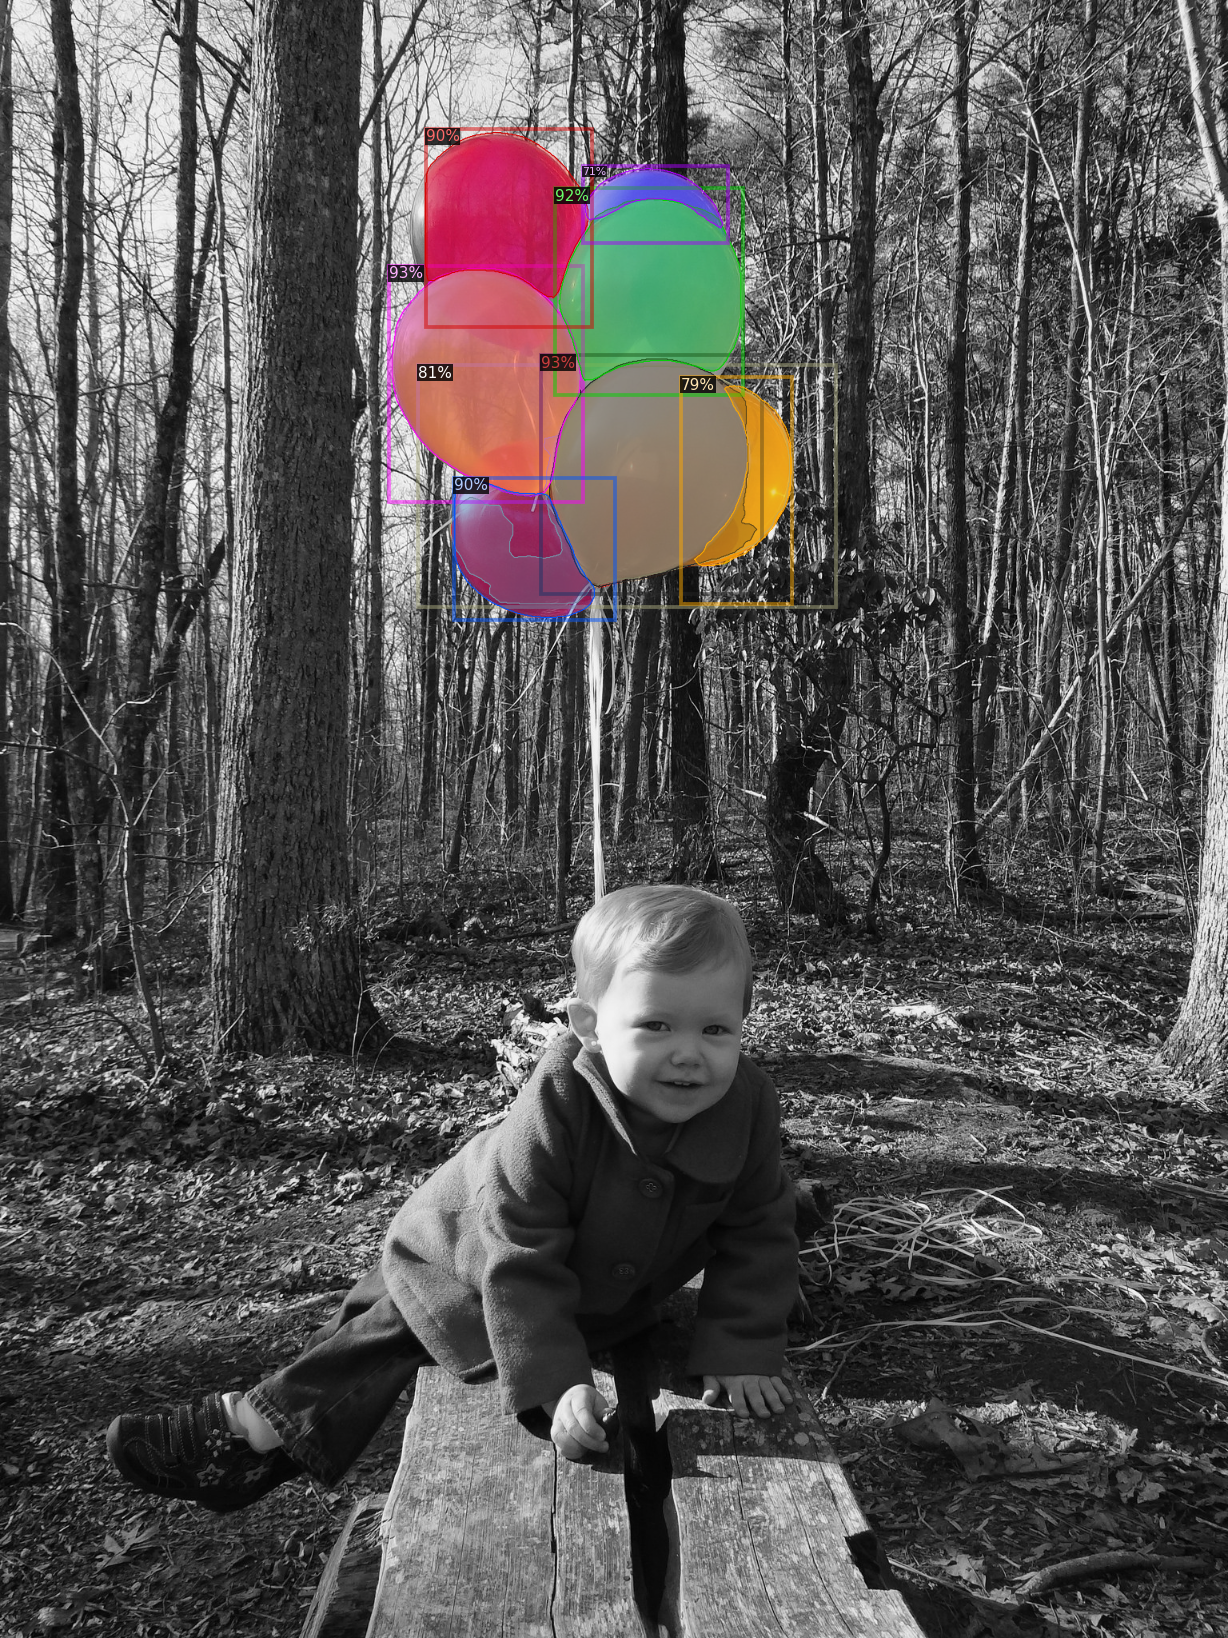

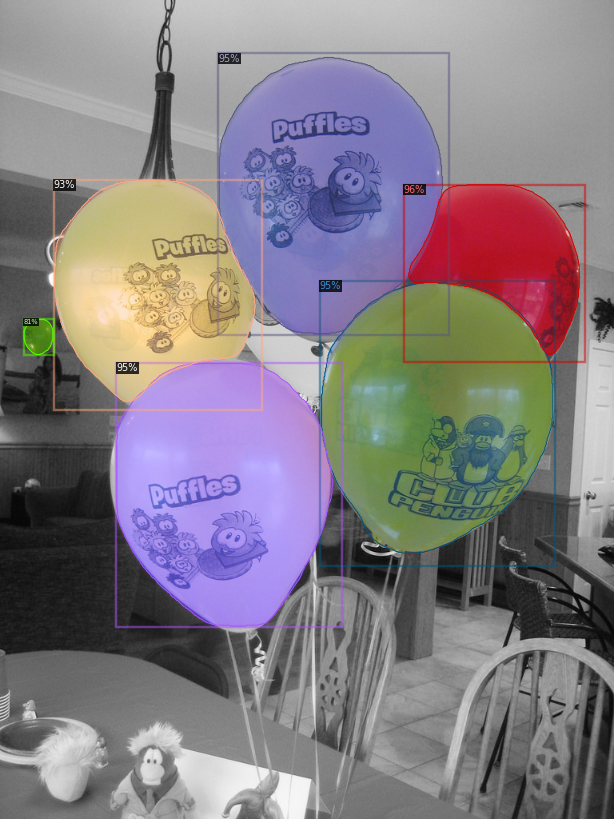

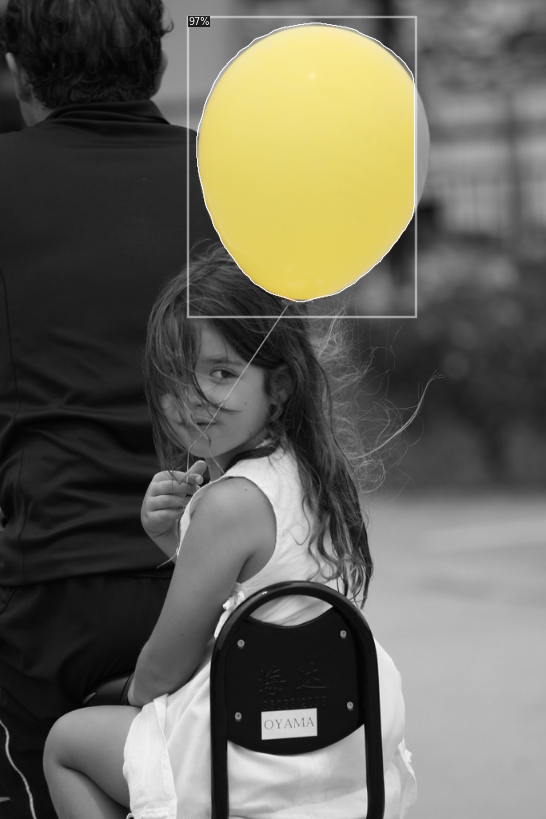

In [0]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_balloon_dicts("balloon/val")
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=balloon_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])

We can also evaluate its performance using AP metric implemented in COCO API.
This gives an AP of ~70%. Not bad!

In [0]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("balloon_val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "balloon_val")
inference_on_dataset(trainer.model, val_loader, evaluator)
# another equivalent way is to use trainer.test

[11/15 04:10:32 d2.evaluation.evaluator]: Start inference on 13 images
[11/15 04:10:46 d2.evaluation.evaluator]: Total inference time: 0:00:05 (0.625000 s / img per device, on 1 devices)
[11/15 04:10:46 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:03 (0.437190 s / img per device, on 1 devices)
[11/15 04:10:46 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[11/15 04:10:46 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[11/15 04:10:46 d2.evaluation.coco_evaluation]: Evaluating predictions ...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.13s).
Accumulating evaluation results...
DONE (t=0.02s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.681
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.849
 Average Precision  (AP) @[ IoU=0.75      | area

OrderedDict([('bbox',
              {'AP': 68.13251528146942,
               'AP50': 84.9277873853965,
               'AP75': 82.8068039080166,
               'APl': 81.58885128967246,
               'APm': 57.23126698500541,
               'APs': 1.1056105610561056}),
             ('segm',
              {'AP': 76.97562111397131,
               'AP50': 84.64734364022362,
               'AP75': 84.01711775272273,
               'APl': 93.63197968598362,
               'APm': 58.887208805837645,
               'APs': 0.763201320132013})])

# Other types of builtin models

WARNING [10/15 06:33:32 d2.config.compat]: Config './detectron2_repo/configs/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


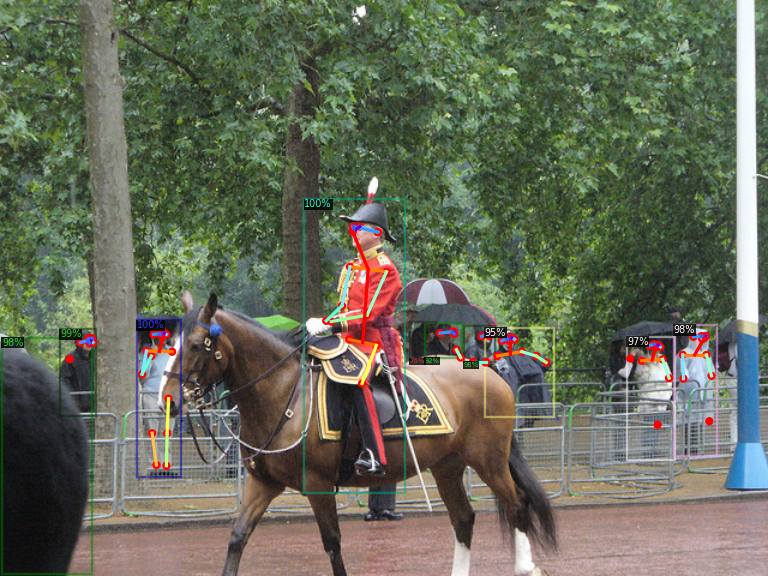

In [0]:
# Inference with a keypoint detection model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # set threshold for this model
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)
outputs = predictor(im)
v = Visualizer(im[:,:,::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(v.get_image()[:, :, ::-1])

WARNING [10/15 06:33:37 d2.config.compat]: Config './detectron2_repo/configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


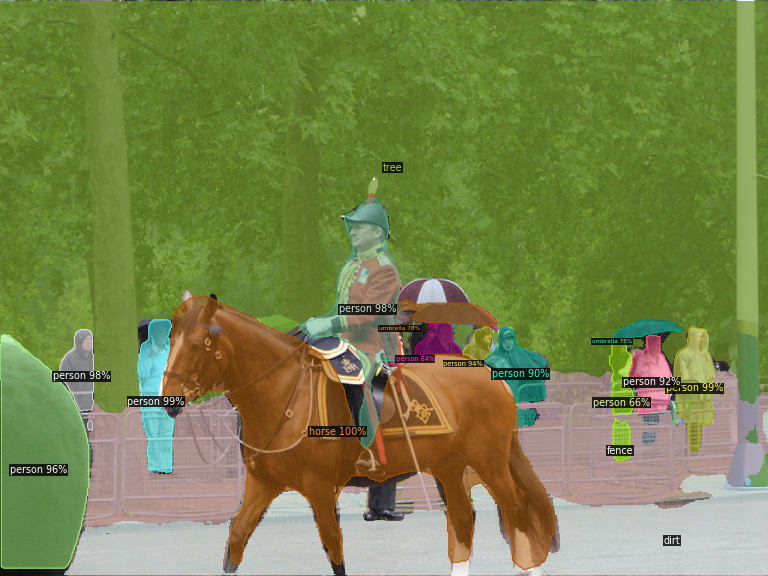

In [0]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(v.get_image()[:, :, ::-1])

# Run panoptic segmentation on a video

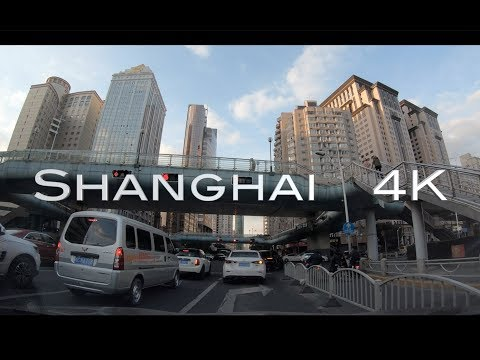

In [0]:
# This is the video we're going to process
from IPython.display import YouTubeVideo, display
video = YouTubeVideo("ll8TgCZ0plk", width=500)
display(video)

In [0]:
# Install dependencies, download the video, and crop 5 seconds for processing
!pip install youtube-dl
!pip uninstall -y opencv-python opencv-contrib-python
!apt install python3-opencv  # the one pre-installed have some issues
!youtube-dl https://www.youtube.com/watch?v=ll8TgCZ0plk -f 22 -o video.mp4
!ffmpeg -i video.mp4 -t 00:00:06 -c:v copy video-clip.mp4

In [0]:
# Run frame-by-frame inference demo on this video (takes 3-4 minutes)
# Using a model trained on COCO dataset
!cd detectron2_repo && python demo/demo.py --config-file configs/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml --video-input ../video-clip.mp4 --confidence-threshold 0.6 --output ../video-output.mkv \
  --opts MODEL.WEIGHTS detectron2://COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl

In [0]:
# Download the results
from google.colab import files
files.download('video-output.mkv')